In [ ]:
import numpy as np
import tensorflow as tf

def dequantize_tensor(tensor, scale, zero_point):
    """Dequantize a tensor using its scale and zero-point."""
    return (tensor.astype(np.float32) - zero_point) * scale

model_path = "trained.tflite"
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()
details = interpreter.get_tensor_details()

weights = {}
biases = {}

for detail in details:
    try:
        tensor = interpreter.get_tensor(detail['index'])
        if "MatMul" in detail['name'] and "sequential" in detail['name']:
            if 'quantization_parameters' in detail:
                scale = detail['quantization_parameters']['scales'][0]
                zero_point = detail['quantization_parameters']['zero_points'][0]
                weights[detail['name']] = {
                    'data': tensor,
                    'scale': scale,
                    'zero_point': zero_point,
                    'dequantized': dequantize_tensor(tensor, scale, zero_point)
                }
            else:
                print(f"Skipping {detail['name']}: No quantization parameters found.")
        elif "BiasAdd" in detail['name'] and "sequential" in detail['name']:
            if 'quantization_parameters' in detail:
                scale = detail['quantization_parameters']['scales'][0]
                zero_point = detail['quantization_parameters']['zero_points'][0]
                biases[detail['name']] = {
                    'data': tensor,
                    'scale': scale,
                    'zero_point': zero_point,
                    'dequantized': dequantize_tensor(tensor, scale, zero_point)
                }
            else:
                print(f"Skipping {detail['name']}: No quantization parameters found.")
    except ValueError as e:
        print(f"Error accessing tensor {detail['name']}: {e}")

np.save("weights.npy", weights)
np.save("biases.npy", biases)

print("Weights and biases extraction Ended.")

Error accessing tensor sequential/dense/MatMul;sequential/dense/Relu;sequential/dense/BiasAdd: Tensor data is null. Run allocate_tensors() first
Error accessing tensor sequential/dense_1/MatMul;sequential/dense_1/Relu;sequential/dense_1/BiasAdd: Tensor data is null. Run allocate_tensors() first
Error accessing tensor sequential/dense_2/MatMul;sequential/dense_2/Relu;sequential/dense_2/BiasAdd: Tensor data is null. Run allocate_tensors() first
Weights and biases extraction Ended.


In [ ]:
import numpy as np

weights = np.load("weights.npy", allow_pickle=True).item()
print("Weights:")
for key, value in weights.items():
    print(f"{key}: Shape={value['dequantized'].shape}, Data={value['dequantized']}")

biases = np.load("biases.npy", allow_pickle=True).item()
print("\nBiases:")
for key, value in biases.items():
    print(f"{key}: Shape={value['dequantized'].shape}, Data={value['dequantized']}")

Weights:
sequential/y_pred/MatMul: Shape=(4, 256), Data=[[-0.03608756 -0.08248586 -0.18215628 ...  0.10826269 -0.06530131
  -0.04296139]
 [-0.09279659 -0.14091335 -0.08764123 ... -0.0309322  -0.13575798
   0.17871937]
 [-0.0463983  -0.0463983   0.1116996  ... -0.03780602 -0.17700091
  -0.21824384]
 [-0.18731165 -0.13060261  0.1116996  ... -0.07561204  0.0618644
  -0.15466099]]
sequential/dense_2/MatMul: Shape=(256, 256), Data=[[ 0.09081285  0.05146061 -0.02270321 ...  0.05448771  0.02270321
   0.03481159]
 [ 0.04691997 -0.10897542  0.01362193 ... -0.01664902  0.04389288
  -0.04994707]
 [-0.10897542  0.08173156  0.07567737 ... -0.07113673 -0.0287574
   0.0575148 ]
 ...
 [ 0.07265028 -0.10443478  0.01362193 ...  0.04843352 -0.07416383
   0.01513547]
 [-0.08778575 -0.00302709 -0.08627221 ... -0.0575148  -0.10292123
   0.06659609]
 [-0.02724385 -0.0892993   0.04994707 ...  0.08778575  0.09383994
   0.12562444]]
sequential/dense_1/MatMul: Shape=(256, 256), Data=[[ 0.02404338  0.04293461 -0.

In [25]:
import numpy as np

# Load weights and biases
weights = np.load("weights.npy", allow_pickle=True).item()
biases = np.load("biases.npy", allow_pickle=True).item()

# Function to sanitize variable names
def sanitize_name(name):
    return name.replace('/', '_').replace(';', '_')

# Function to extract the last part of the name
def clear_name(name):
    parts = name.rsplit(";")
    return parts[-1]

# Generate the C header file
with open("model_weights.h", "w") as f:
    f.write("#ifndef MODEL_WEIGHTS_H\n")
    f.write("#define MODEL_WEIGHTS_H\n\n")

    # Write weights
    for key, value in weights.items():
        sanitized_key = sanitize_name(clear_name(key))
        dequantized_data = value['dequantized']
        if dequantized_data.size > 0:
            # Calculate the size of the array
            array_size = dequantized_data.size
            # Write the array declaration with size
            f.write(f"static const float {sanitized_key}[{array_size}] = {{\n")
            if dequantized_data.ndim == 1:
                f.write("    " + ", ".join(map(str, dequantized_data)) + ",\n")
            else:
                for row in dequantized_data:
                    f.write("    " + ", ".join(map(str, row)) + ",\n")
            f.write("};\n\n")

    # Write biases
    for key, value in biases.items():
        sanitized_key = sanitize_name(clear_name(key))
        dequantized_data = value['dequantized']
        if dequantized_data.size > 0:
            # Calculate the size of the array
            array_size = dequantized_data.size
            # Write the array declaration with size
            f.write(f"static const float {sanitized_key}[{array_size}] = {{\n")
            f.write("    " + ", ".join(map(str, dequantized_data)) + ",\n")
            f.write("};\n\n")

    f.write("#endif // MODEL_WEIGHTS_H\n")


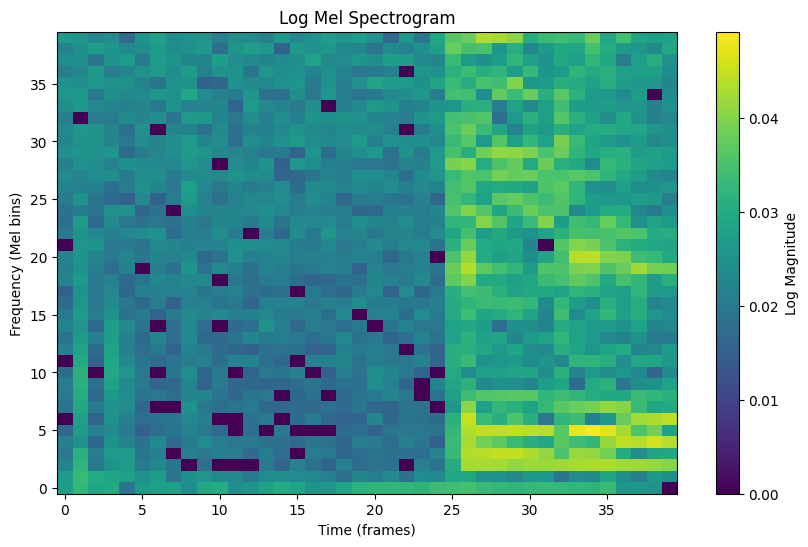

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Load the spectrogram data from the file
spectrogram = np.loadtxt("spectrogram.txt")

# Plot the spectrogram
plt.figure(figsize=(10, 6))
plt.imshow(spectrogram.T, aspect="auto", origin="lower", cmap="viridis")
plt.colorbar(label="Log Magnitude")
plt.xlabel("Time (frames)")
plt.ylabel("Frequency (Mel bins)")
plt.title("Log Mel Spectrogram")
plt.show()

In [22]:
import numpy as np
from scipy.fftpack import dct
from scipy.signal import istft
from scipy.io.wavfile import write
from scipy.interpolate import interp1d

# Load the spectrogram data from the file
spectrogram = np.loadtxt("spectrogram.txt")

# Convert log Mel spectrogram to linear scale
spectrogram_linear = np.power(10, spectrogram)

# Upsample the spectrogram to match the expected number of frequency bins
original_freq_bins = np.arange(spectrogram_linear.shape[1])
target_freq_bins = np.linspace(0, spectrogram_linear.shape[1] - 1, num=257)
upsampled_spectrogram = np.zeros((spectrogram_linear.shape[0], 257))
for i in range(spectrogram_linear.shape[0]):
    interp_func = interp1d(original_freq_bins, spectrogram_linear[i], kind='linear', fill_value="extrapolate")
    upsampled_spectrogram[i] = interp_func(target_freq_bins)
spectrogram_linear = upsampled_spectrogram

# Approximate the magnitude spectrogram using inverse DCT (if working with Mel spectrogram)
magnitude_spectrogram = dct(spectrogram_linear, type=2, norm='ortho')

# Generate random phase (or assume zero phase)
phase = np.random.uniform(-np.pi, np.pi, magnitude_spectrogram.shape)

# Combine magnitude and phase to create a complex spectrogram
complex_spectrogram = magnitude_spectrogram * np.exp(1j * phase)

# Transpose the spectrogram to match the expected shape (n_freq_bins, n_time_frames)
complex_spectrogram = complex_spectrogram.T

# Perform ISTFT
nperseg = 512  # Number of samples per segment (FFT size)
noverlap = 256  # Number of overlapping samples
t, reconstructed_audio = istft(complex_spectrogram, fs=16000, nperseg=nperseg, noverlap=noverlap)

# Normalize the audio to the range [-1, 1]
reconstructed_audio = reconstructed_audio / np.max(np.abs(reconstructed_audio))

# Save the audio to a WAV file
write("reconstructed_audio.wav", 16000, reconstructed_audio.astype(np.float32))